In [10]:
%pip install numpy
import numpy as np
import pandas as pd
np.random.seed(42)
N = 20000  # number of users




Note: you may need to restart the kernel to use updated packages.


In [11]:
# 1. Basic identifiers
user_id = np.arange(1, N + 1)

In [12]:
# 2. Demographics
age = np.clip(np.random.normal(loc=35, scale=10, size=N), 18, 70).astype(int)
countries = ["US", "UK", "IN", "CA", "DE", "BR", "AU"]
country_probs = [0.35, 0.1, 0.2, 0.1, 0.1, 0.1, 0.05]
country = np.random.choice(countries, size=N, p=country_probs)

In [13]:
# 3. Subscription tenure (months)
months_subscribed = np.random.randint(1, 61, size=N)  # 1–60 months

In [14]:
# 4. Plan type
plan_types = ["basic", "standard", "premium"]
plan_probs = [0.4, 0.4, 0.2]
plan_type = np.random.choice(plan_types, size=N, p=plan_probs)

In [15]:
# 5. Payment method
payment_methods = ["credit_card", "paypal", "gift_card", "bank_transfer"]
payment_probs = [0.5, 0.2, 0.1, 0.2]
payment_method = np.random.choice(payment_methods, size=N, 
p=payment_probs)

In [16]:
# 6. Devices / profiles
# more devices for higher plans
num_devices = (
    np.where(plan_type == "basic", np.random.randint(1, 3, size=N),
    np.where(plan_type == "standard", np.random.randint(2, 4, size=N),
             np.random.randint(3, 6, size=N)))
)

In [17]:
# 7. Add-ons
has_4k = np.where(plan_type == "premium",
                  np.random.binomial(1, 0.7, size=N),
                  np.random.binomial(1, 0.05, size=N))
has_offline_downloads = np.random.binomial(1, 0.4, size=N)


In [18]:
# 8. Monthly price (roughly based on plan + add-ons)
base_price = np.where(plan_type == "basic", 9.99,
             np.where(plan_type == "standard", 14.99, 19.99))
monthly_price = (
    base_price
    + has_4k * 3.0
    + has_offline_downloads * 1.5
    + np.random.normal(0, 0.75, size=N)  # small noise
)
monthly_price = np.round(monthly_price, 2)

In [19]:
# 9. Engagement – watch hours per last 30 days
# More expensive plans tend to watch slightly more
plan_watch_factor = np.where(plan_type == "basic", 1.0,
                     np.where(plan_type == "standard", 1.15, 1.3))
base_watch = np.random.gamma(shape=2.0, scale=8.0, size=N)  # ~0–80 hours
watch_hours_30d = base_watch * plan_watch_factor
watch_hours_30d = np.clip(watch_hours_30d, 0, 120)

In [20]:
# 10. Engagement last 7 days – could have dropped/increased
eng_change_factor = np.random.normal(loc=0.25, scale=0.15, size=N)
# convert 30d to 7d baseline (~1/4) then apply change
watch_hours_7d = (watch_hours_30d / 4.0) * (1 + eng_change_factor)
watch_hours_7d = np.clip(watch_hours_7d, 0, None)

In [21]:
# 11. Days since last watch (if very low engagement, often high)
base_inactivity = np.random.randint(0, 15, size=N)
extra_inactivity = np.where(watch_hours_7d < 3, np.random.randint(0, 20, 
size=N), 0)
days_since_last_watch = np.clip(base_inactivity + extra_inactivity, 0, 45)

In [22]:
# 12. Genre diversity & binge behaviour
genre_diversity = np.clip(
np.random.poisson(lam=3 + watch_hours_30d / 30, size=N), 1, 15
)
binge_sessions = np.clip(
    np.random.poisson(lam=watch_hours_30d / 15, size=N), 0, 20
)

In [23]:
# 13. Support tickets & payment failures
support_tickets = np.clip(
    np.random.poisson(lam=0.2 + (days_since_last_watch > 20) * 0.3, size=N),
    0,
    10,
)
payment_failures = np.clip(np.random.poisson(lam=0.1 + (monthly_price > 18) * 0.2, size=N),
    0,
    6,
)

In [24]:
# 14. Discount usage
discount_used = np.random.binomial(1, 0.3, size=N)

In [25]:
# 15. Lifetime value & engagement drop ratio
lifetime_value = monthly_price * months_subscribed
engagement_drop_ratio = np.where(
    watch_hours_30d > 0,
    watch_hours_7d / (watch_hours_30d / 4.0),  # compare 7d vs "expected" 7d
    0,
)
# clip extreme ratios
engagement_drop_ratio = np.clip(engagement_drop_ratio, 0, 2.5)

In [26]:
# 16. Compute churn probability using a scoring formula
# Start with a base probability
base_p = 0.15
# More likely to churn if:
p = np.full(N, base_p)
# Low watch in 30 days
p += np.where(watch_hours_30d < 10, 0.12, 0)
p += np.where(watch_hours_30d < 5, 0.10, 0)
# Big engagement drop (ratio < 0.7)
p += np.where(engagement_drop_ratio < 0.7, 0.15, 0)
# Many days since last watch
p += (days_since_last_watch / 60.0)
# Many payment failures
p += payment_failures * 0.06
# Many support tickets
p += support_tickets * 0.03
# Very new users churn more
p += np.where(months_subscribed <= 3, 0.10, 0)
# Very long-tenure users churn less
p -= np.where(months_subscribed > 24, 0.06, 0)
# Premium users churn slightly less
p -= np.where(plan_type == "premium", 0.05, 0)
# ensure probabilities are between 0.01 and 0.8
p = np.clip(p, 0.01, 0.8)


In [27]:
# 17. Sample actual churn outcome from Bernoulli distribution
churn = np.random.binomial(1, p, size=N)

In [28]:
# 18. Build DataFrame
df = pd.DataFrame({
    "user_id": user_id,
    "age": age,
    "country": country,
    "months_subscribed": months_subscribed,
    "plan_type": plan_type,
    "payment_method": payment_method,
    "num_devices": num_devices,
    "has_4k": has_4k,
    "has_offline_downloads": has_offline_downloads,
    "monthly_price": monthly_price,
    "watch_hours_30d": watch_hours_30d,
    "watch_hours_7d": watch_hours_7d,
    "days_since_last_watch": days_since_last_watch,
    "genre_diversity": genre_diversity,
    "binge_sessions": binge_sessions,
    "support_tickets": support_tickets,
    "payment_failures": payment_failures,
    "discount_used": discount_used,
    "lifetime_value": lifetime_value,
    "engagement_drop_ratio": engagement_drop_ratio,
    "churn": churn
})


In [29]:
# 19. Save to CSV
df.to_csv("streaming_churn_20k.csv", index=False)
print("Saved dataset with shape:", df.shape)
print(df.head())

Saved dataset with shape: (20000, 21)
   user_id  age country  months_subscribed plan_type payment_method  \
0        1   39      US                 12     basic    credit_card   
1        2   33      AU                 58  standard  bank_transfer   
2        3   41      DE                 49     basic    credit_card   
3        4   50      BR                 34  standard         paypal   
4        5   32      CA                 49  standard         paypal   

   num_devices  has_4k  has_offline_downloads  monthly_price  ...  \
0            1       0                      1          12.06  ...   
1            2       1                      0          18.44  ...   
2            1       0                      1          10.16  ...   
3            2       0                      1          16.52  ...   
4            2       0                      1          16.79  ...   

   watch_hours_7d  days_since_last_watch  genre_diversity  binge_sessions  \
0        6.818861                      1   

In [30]:
#PHASE 2 EXPLORATORY DATA ANALYSIS[EDA]
#1 EDA BASIC CHECKING
import pandas as pd

df = pd.read_csv("streaming_churn_20k.csv")
df.info()
df.describe(include="all")
df["churn"].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                20000 non-null  int64  
 1   age                    20000 non-null  int64  
 2   country                20000 non-null  object 
 3   months_subscribed      20000 non-null  int64  
 4   plan_type              20000 non-null  object 
 5   payment_method         20000 non-null  object 
 6   num_devices            20000 non-null  int64  
 7   has_4k                 20000 non-null  int64  
 8   has_offline_downloads  20000 non-null  int64  
 9   monthly_price          20000 non-null  float64
 10  watch_hours_30d        20000 non-null  float64
 11  watch_hours_7d         20000 non-null  float64
 12  days_since_last_watch  20000 non-null  int64  
 13  genre_diversity        20000 non-null  int64  
 14  binge_sessions         20000 non-null  int64  
 15  su

churn
0    0.6663
1    0.3337
Name: proportion, dtype: float64

Note: you may need to restart the kernel to use updated packages.


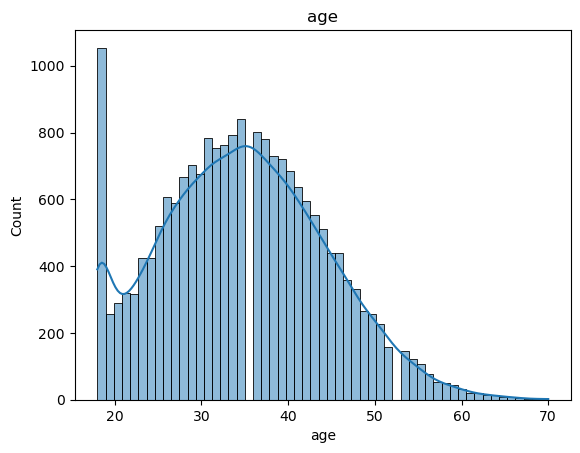

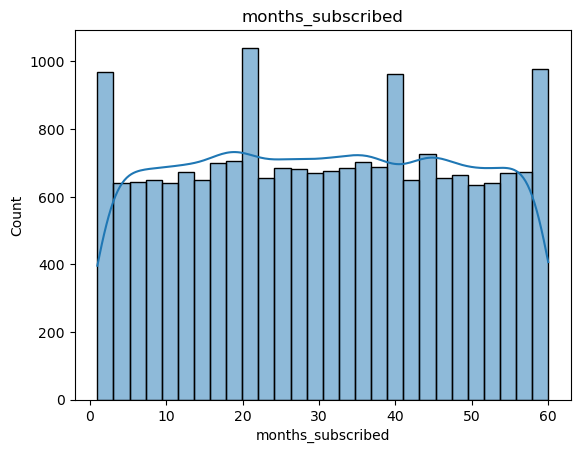

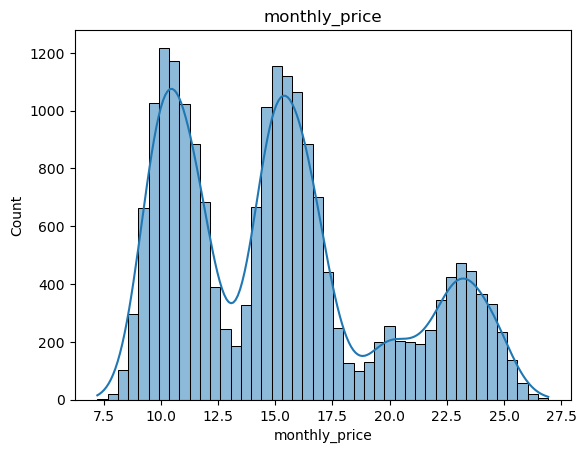

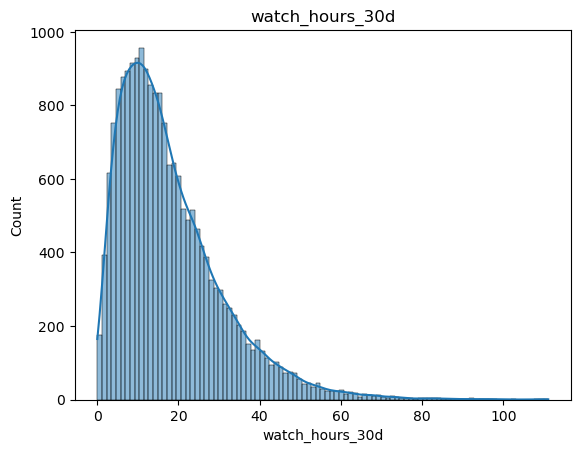

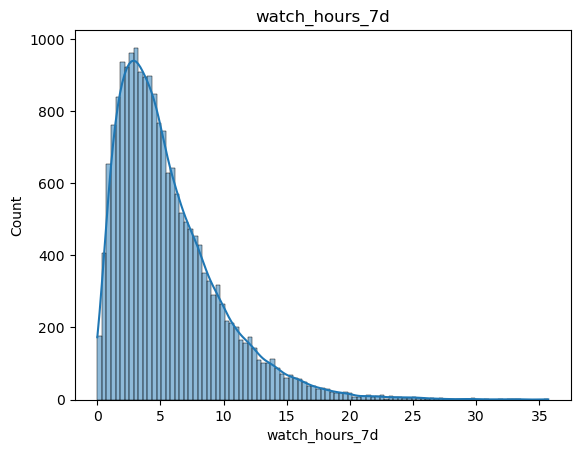

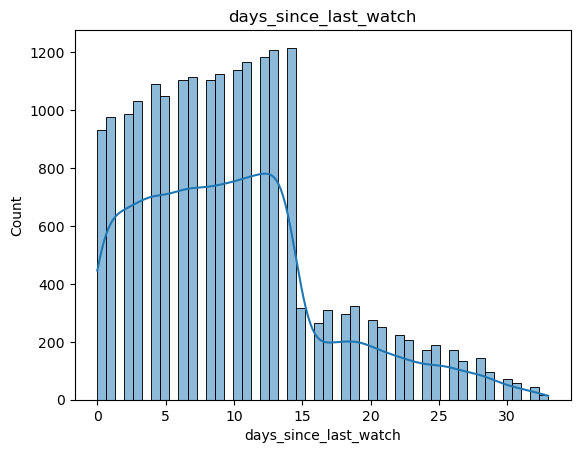

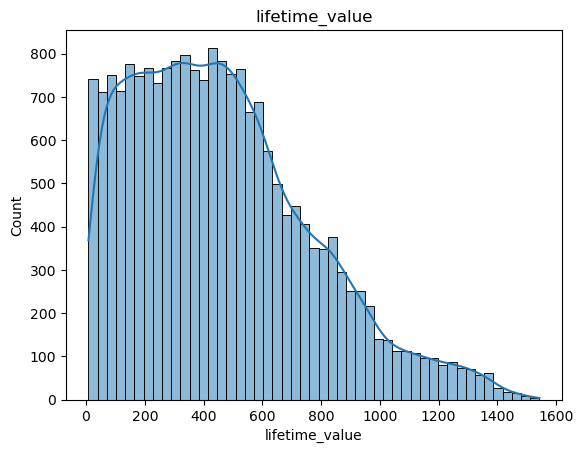

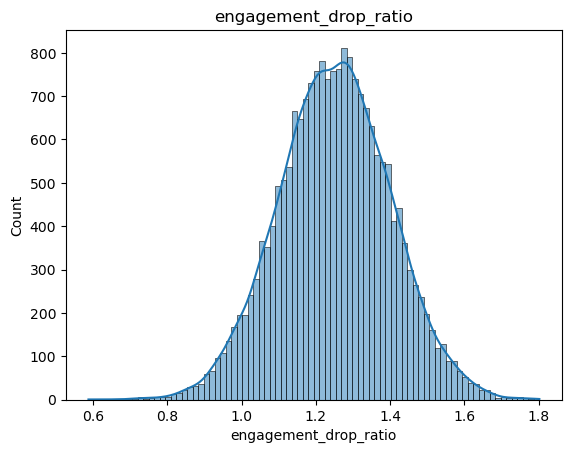

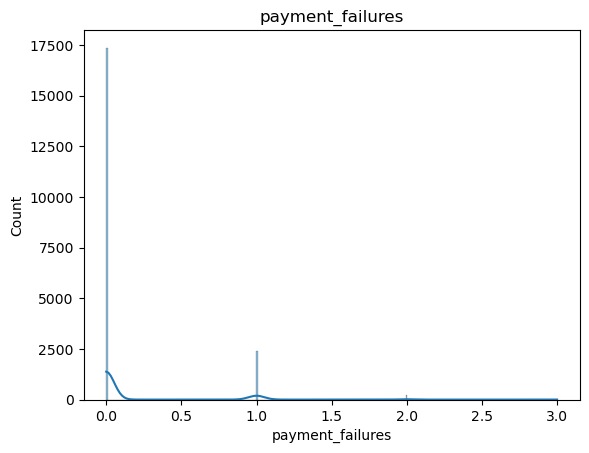

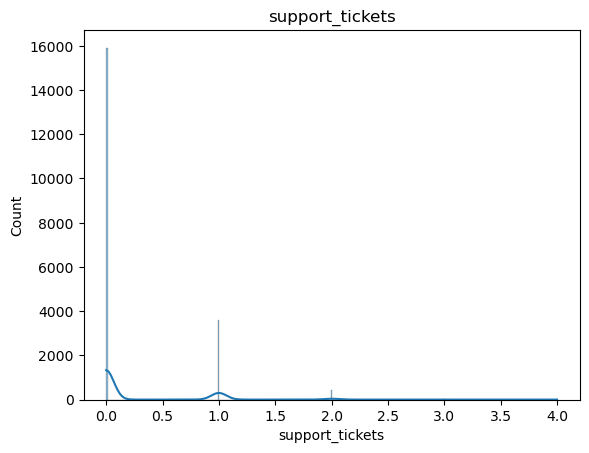

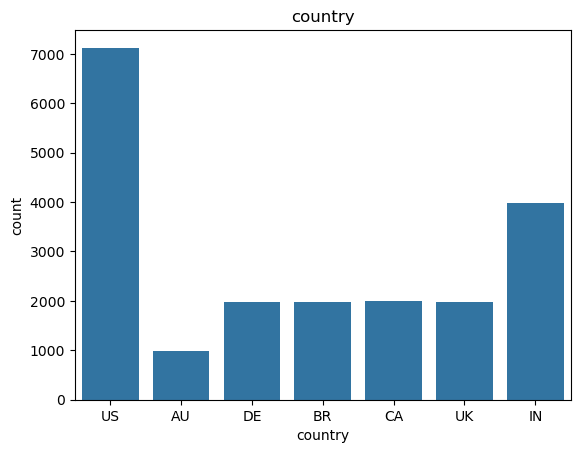

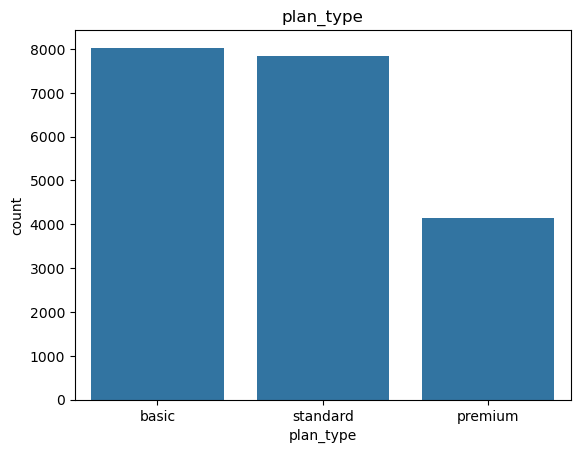

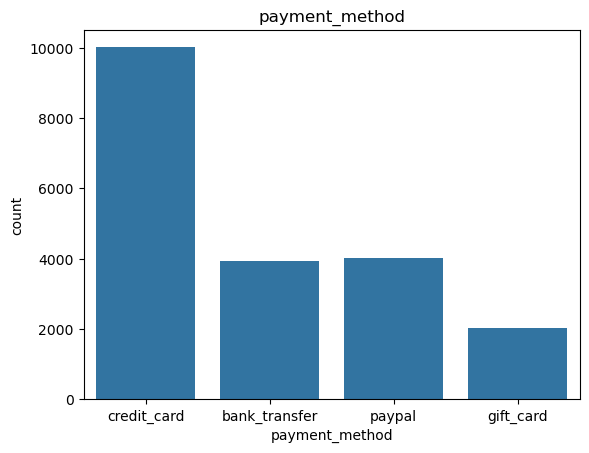

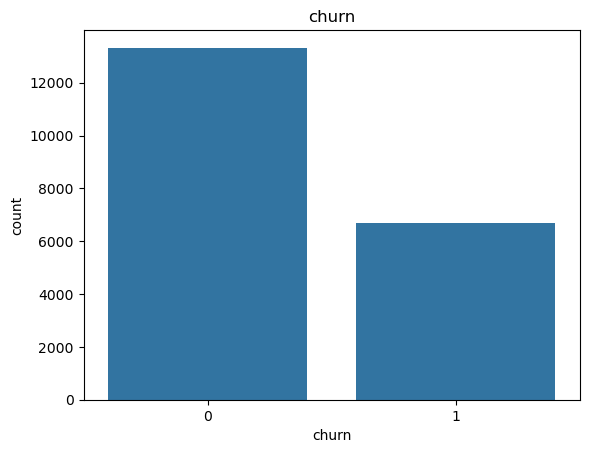

In [31]:
#2 UNIVARIATE EDA
%pip install pandas numpy scikit-learn seaborn matplotlib shap joblib streamlit plotly

import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["age","months_subscribed","monthly_price","watch_hours_30d",
            "watch_hours_7d","days_since_last_watch","lifetime_value",
            "engagement_drop_ratio","payment_failures","support_tickets"]
cat_cols = ["country","plan_type","payment_method","churn"]

for col in num_cols:
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.show()

for col in cat_cols:
    sns.countplot(data=df, x=col)
    plt.title(col)
    plt.show()


In [106]:
#3 SINGLE VS CHURN
# Churn rate by plan
print(df.groupby("plan_type")["churn"].mean())

# Churn rate by country
print(df.groupby("country")["churn"].mean())

# Churn vs engagement buckets
df["watch_bucket"] = pd.cut(df["watch_hours_30d"], bins=[0,10,30,60,120],
                            labels=["0-10","10-30","30-60","60-120"])
print(df.groupby("watch_bucket")["churn"].mean())


plan_type
basic       0.352223
premium     0.292907
standard    0.336224
Name: churn, dtype: float64
country
AU    0.350663
BR    0.349391
CA    0.331994
DE    0.342119
IN    0.325552
UK    0.322368
US    0.332865
Name: churn, dtype: float64
watch_bucket
0-10      0.539014
10-30     0.245915
30-60     0.235131
60-120    0.204762
Name: churn, dtype: float64


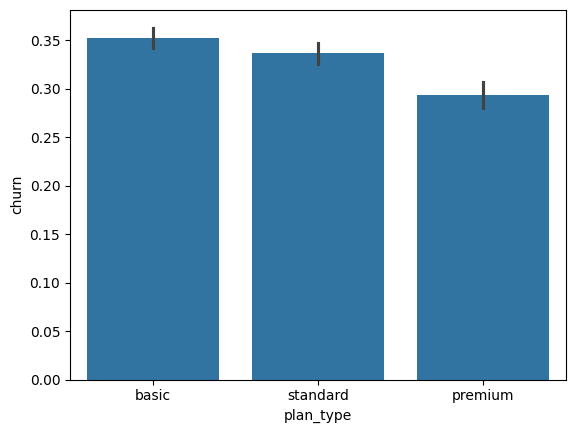

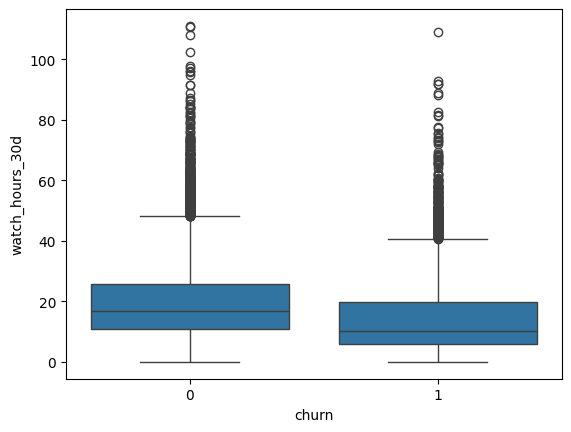

In [107]:
sns.barplot(data=df, x="plan_type", y="churn")
plt.show()

sns.boxplot(data=df, x="churn", y="watch_hours_30d")
plt.show()


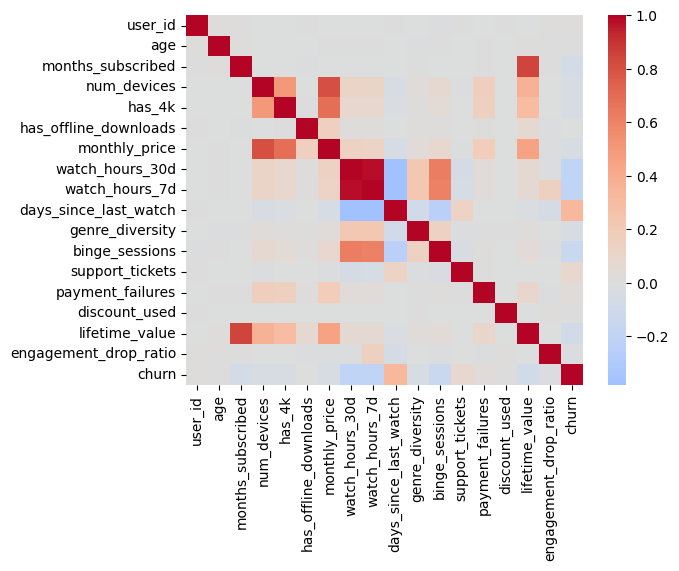

churn                    1.000000
days_since_last_watch    0.329457
support_tickets          0.080185
payment_failures         0.026488
user_id                  0.017029
discount_used            0.003831
age                      0.003822
has_offline_downloads    0.000081
engagement_drop_ratio   -0.018274
has_4k                  -0.039108
num_devices             -0.043888
genre_diversity         -0.044630
monthly_price           -0.045250
months_subscribed       -0.072744
lifetime_value          -0.086147
binge_sessions          -0.136070
watch_hours_30d         -0.195112
watch_hours_7d          -0.195669
Name: churn, dtype: float64

In [108]:
#4 CORRELATIONS
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.show()

corr["churn"].sort_values(ascending=False)


In [109]:
# PHASE 3 : FEATURED ENGINEERING
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [110]:

#1. LOAD DATA
df = pd.read_csv("streaming_churn_20k.csv")   # generated in Phase 1
print("Shape:", df.shape)
print(df.head())

Shape: (20000, 21)
   user_id  age country  months_subscribed plan_type payment_method  \
0        1   39      US                 12     basic    credit_card   
1        2   33      AU                 58  standard  bank_transfer   
2        3   41      DE                 49     basic    credit_card   
3        4   50      BR                 34  standard         paypal   
4        5   32      CA                 49  standard         paypal   

   num_devices  has_4k  has_offline_downloads  monthly_price  ...  \
0            1       0                      1          12.06  ...   
1            2       1                      0          18.44  ...   
2            1       0                      1          10.16  ...   
3            2       0                      1          16.52  ...   
4            2       0                      1          16.79  ...   

   watch_hours_7d  days_since_last_watch  genre_diversity  binge_sessions  \
0        6.818861                      1                7     

In [111]:
# -------------------------------------------------------------------
# 2. BASIC CLEANING / SETUP
# -------------------------------------------------------------------

# Ensure correct dtypes
categorical_cols = ["country", "plan_type", "payment_method"]
binary_cols = ["has_4k", "has_offline_downloads", "discount_used"]
numeric_cols = [
    "age",
    "months_subscribed",
    "num_devices",
    "monthly_price",
    "watch_hours_30d",
    "watch_hours_7d",
    "days_since_last_watch",
    "genre_diversity",
    "binge_sessions",
    "support_tickets",
    "payment_failures",
    "lifetime_value",
    "engagement_drop_ratio"
]

# Quick check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# (Optional) simple imputation example
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# -------------------------------------------------------------------
# 3. BEHAVIOR-BASED FEATURES
# -------------------------------------------------------------------

# Engagement drop ratio (recompute for clarity)
# compare 7d vs "expected" 7d from 30d
eps = 1e-6
expected_7d = df["watch_hours_30d"] / 4.0
df["engagement_drop_ratio_fe"] = np.where(
    expected_7d > 0,
    df["watch_hours_7d"] / (expected_7d + eps),
    0.0
)
df["engagement_drop_ratio_fe"] = df["engagement_drop_ratio_fe"].clip(0, 2.5)

# Inactivity flag (> 14 days since last watch)
df["inactivity_flag"] = (df["days_since_last_watch"] > 14).astype(int)

# Binge ratio: binge sessions per watch hour (30d)
df["binge_ratio"] = df["binge_sessions"] / (df["watch_hours_30d"] + eps)

# Engagement intensity buckets (optional categorical buckets)
def bucket_watch_hours(x):
    if x < 5:
        return "low"
    elif x < 20:
        return "medium"
    else:
        return "high"

df["watch_30d_bucket"] = df["watch_hours_30d"].apply(bucket_watch_hours)



Missing values per column:
user_id                  0
age                      0
country                  0
months_subscribed        0
plan_type                0
payment_method           0
num_devices              0
has_4k                   0
has_offline_downloads    0
monthly_price            0
watch_hours_30d          0
watch_hours_7d           0
days_since_last_watch    0
genre_diversity          0
binge_sessions           0
support_tickets          0
payment_failures         0
discount_used            0
lifetime_value           0
engagement_drop_ratio    0
churn                    0
dtype: int64


In [112]:
# -------------------------------------------------------------------
# 4. SUBSCRIPTION & REVENUE FEATURES
# -------------------------------------------------------------------

# Lifetime value (recompute for clarity)
df["lifetime_value_fe"] = df["monthly_price"] * df["months_subscribed"]

# Plan dummies (basic / standard / premium)
df["is_basic"] = (df["plan_type"] == "basic").astype(int)
df["is_standard"] = (df["plan_type"] == "standard").astype(int)
df["is_premium"] = (df["plan_type"] == "premium").astype(int)

# High payment risk (>= 2 failures)
df["high_payment_risk"] = (df["payment_failures"] >= 2).astype(int)


In [113]:
# -------------------------------------------------------------------
# 5. CUSTOMER SERVICE / EXPERIENCE FEATURES
# -------------------------------------------------------------------

# Has complained at least once
df["has_complained"] = (df["support_tickets"] > 0).astype(int)

# Simple friction score combining complaints, payment failures, discounts
df["friction_score"] = (
    0.3 * df["support_tickets"] +
    0.5 * df["payment_failures"] +
    0.2 * df["discount_used"]
)

In [114]:
# -------------------------------------------------------------------
# 6. INTERACTION FEATURES
# -------------------------------------------------------------------

# Premium low engagement: expensive plan but low usage
df["premium_low_engagement"] = (
    (df["plan_type"] == "premium") & (df["watch_hours_30d"] < 5)
).astype(int)

# New low engagement: new users with low 30d watch hours
df["new_low_engagement"] = (
    (df["months_subscribed"] <= 3) & (df["watch_hours_30d"] < 5)
).astype(int)

# Long-tenure high engagement
df["loyal_heavy_user"] = (
    (df["months_subscribed"] > 24) & (df["watch_hours_30d"] >= 20)
).astype(int)


In [115]:
# -------------------------------------------------------------------
# 7. ONE-HOT ENCODING OF CATEGORICAL VARIABLES
# -------------------------------------------------------------------

cat_for_encoding = ["country", "plan_type", "payment_method", "watch_30d_bucket"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_array = encoder.fit_transform(df[cat_for_encoding])
encoded_cols = encoder.get_feature_names_out(cat_for_encoding)

encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)

In [116]:
# -------------------------------------------------------------------
# 8. BUILD FINAL MODELING DATAFRAME (X, y)
# -------------------------------------------------------------------

# Target
y = df["churn"]

# Choose numeric + engineered features to scale
num_features_for_scaling = [
    "age",
    "months_subscribed",
    "num_devices",
    "monthly_price",
    "watch_hours_30d",
    "watch_hours_7d",
    "days_since_last_watch",
    "genre_diversity",
    "binge_sessions",
    "support_tickets",
    "payment_failures",
    "lifetime_value_fe",
    "engagement_drop_ratio_fe",
    "binge_ratio",
    "friction_score"
]

binary_and_other_features = [
    "has_4k",
    "has_offline_downloads",
    "discount_used",
    "inactivity_flag",
    "is_basic",
    "is_standard",
    "is_premium",
    "high_payment_risk",
    "has_complained",
    "premium_low_engagement",
    "new_low_engagement",
    "loyal_heavy_user"
]

# Train-test split BEFORE scaling to avoid leakage
X_raw = pd.concat(
    [
        df[num_features_for_scaling + binary_and_other_features],
        encoded_df
    ],
    axis=1
)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.3, random_state=42, stratify=y
)



In [117]:
# -------------------------------------------------------------------
# 9. SCALING NUMERIC FEATURES
# -------------------------------------------------------------------

scaler = StandardScaler()
X_train_scaled = X_train_raw.copy()
X_test_scaled = X_test_raw.copy()

X_train_scaled[num_features_for_scaling] = scaler.fit_transform(
    X_train_raw[num_features_for_scaling]
)
X_test_scaled[num_features_for_scaling] = scaler.transform(
    X_test_raw[num_features_for_scaling]
)

print("\nTrain shape:", X_train_scaled.shape, "Test shape:", X_test_scaled.shape)


Train shape: (14000, 40) Test shape: (6000, 40)


In [118]:
# -------------------------------------------------------------------
# 10. SAVE ARTIFACTS FOR MODELING PHASE
# -------------------------------------------------------------------

X_train_scaled.to_csv("X_train_fe.csv", index=False)
X_test_scaled.to_csv("X_test_fe.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Saved feature-engineered datasets for modeling.")

Saved feature-engineered datasets for modeling.


In [119]:
# === PHASE 4: MODELING (STREAMING CHURN) ===

import numpy as np
import pandas as pd
%pip install xgboost imbalanced-learn
%pip install shap
%pip install streamlit

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# --------------------------------------------------------------------
# 1. LOAD FEATURE-ENGINEERED DATA
# --------------------------------------------------------------------

X_train = pd.read_csv("X_train_fe.csv")
X_test = pd.read_csv("X_test_fe.csv")
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Quick check of churn balance in train
print("\nChurn distribution in train:")
print(pd.Series(y_train).value_counts(normalize=True))

  Using cached xgboost-3.1.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.2-py3-none-win_amd64.whl (72.0 MB)

   ---------------------------------------- 0/3 [xgboost]
   ---------------------------------------- 0/3 [xgboost]
   ---------------------------------------- 0/3 [xgboost]
   ---------------------------------------- 0/3 [xgboost]
   ---------------------------------------- 0/3 [xgboost]
   ------------- -------------------------- 1/3 [sklearn-compat]
   -------------------------- ------------- 2/3 [imbalanced-learn]
   -------------------------- ------------- 2/3 [imbalanced-learn]
   -------------------------- ------------- 2/3 [imbalanced-learn]
   ---------------------------------------- 3/3 [imbalanced-learn]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Train shape: (14000, 40) Test shape: (6000, 40)

In [120]:
# --------------------------------------------------------------------
# 2. OPTIONAL: HANDLE CLASS IMBALANCE WITH SMOTE (ON TRAIN ONLY)
# --------------------------------------------------------------------

use_smote = True

if use_smote:
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    print("\nAfter SMOTE, train shape:", X_train_bal.shape)
    print("Churn distribution after SMOTE:")
    print(pd.Series(y_train_bal).value_counts(normalize=True))
else:
    X_train_bal, y_train_bal = X_train, y_train


After SMOTE, train shape: (18656, 40)
Churn distribution after SMOTE:
1    0.5
0    0.5
Name: proportion, dtype: float64


In [121]:
# --------------------------------------------------------------------
# 3. UTILITY: EVALUATION FUNCTION
# --------------------------------------------------------------------

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    """
    Train model, get predictions and print key metrics.
    """
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec = recall_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_proba)

    print(f"\n===== {name} =====")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1-score      : {f1:.4f}")
    print(f"ROC-AUC       : {roc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_te, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_te, y_pred, digits=3))

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
    }


results = []



In [122]:
# --------------------------------------------------------------------
# 4. BASELINE MODEL 1: LOGISTIC REGRESSION
# --------------------------------------------------------------------

log_reg = LogisticRegression(
    max_iter=500,
    class_weight="balanced",  # helps with imbalance
    n_jobs=-1
)

results.append(
    evaluate_model("Logistic Regression", log_reg,
                   X_train_bal, y_train_bal, X_test, y_test)
)




===== Logistic Regression =====
Accuracy      : 0.6673
Precision     : 0.5013
Recall        : 0.5579
F1-score      : 0.5281
ROC-AUC       : 0.6958

Confusion Matrix:
[[2887 1111]
 [ 885 1117]]

Classification Report:
              precision    recall  f1-score   support

           0      0.765     0.722     0.743      3998
           1      0.501     0.558     0.528      2002

    accuracy                          0.667      6000
   macro avg      0.633     0.640     0.636      6000
weighted avg      0.677     0.667     0.671      6000



In [123]:
# --------------------------------------------------------------------
# 5. BASELINE MODEL 2: DECISION TREE
# --------------------------------------------------------------------

dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)

results.append(
    evaluate_model("Decision Tree", dt,
                   X_train_bal, y_train_bal, X_test, y_test)
)




===== Decision Tree =====
Accuracy      : 0.7040
Precision     : 0.5739
Recall        : 0.4386
F1-score      : 0.4972
ROC-AUC       : 0.6856

Confusion Matrix:
[[3346  652]
 [1124  878]]

Classification Report:
              precision    recall  f1-score   support

           0      0.749     0.837     0.790      3998
           1      0.574     0.439     0.497      2002

    accuracy                          0.704      6000
   macro avg      0.661     0.638     0.644      6000
weighted avg      0.690     0.704     0.692      6000



In [124]:
# --------------------------------------------------------------------
# 6. ADVANCED MODEL 1: RANDOM FOREST (WITH LIGHT GRID SEARCH)
# --------------------------------------------------------------------

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=20,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

param_grid_rf = {
    "n_estimators": [150, 200],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [10, 20]
}

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_rf.fit(X_train_bal, y_train_bal)

best_rf = grid_rf.best_estimator_
print("\nBest RandomForest params:", grid_rf.best_params_)

results.append(
    evaluate_model("Random Forest (tuned)", best_rf,
                   X_train_bal, y_train_bal, X_test, y_test)
)


Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best RandomForest params: {'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 200}

===== Random Forest (tuned) =====
Accuracy      : 0.7020
Precision     : 0.5635
Recall        : 0.4740
F1-score      : 0.5149
ROC-AUC       : 0.7025

Confusion Matrix:
[[3263  735]
 [1053  949]]

Classification Report:
              precision    recall  f1-score   support

           0      0.756     0.816     0.785      3998
           1      0.564     0.474     0.515      2002

    accuracy                          0.702      6000
   macro avg      0.660     0.645     0.650      6000
weighted avg      0.692     0.702     0.695      6000



In [125]:
# --------------------------------------------------------------------
# 7. ADVANCED MODEL 2: XGBOOST (OPTIONAL, IF INSTALLED)
# --------------------------------------------------------------------
# pip install xgboost if needed

try:
    from xgboost import XGBClassifier

    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=1.0,  # you can set >1 if churn is rare
        random_state=42,
        n_jobs=-1
    )

    results.append(
        evaluate_model("XGBoost", xgb,
                       X_train_bal, y_train_bal, X_test, y_test)
    )

except ImportError:
    print("\nXGBoost not installed; skipping XGB model.")



===== XGBoost =====
Accuracy      : 0.7142
Precision     : 0.6134
Recall        : 0.3876
F1-score      : 0.4751
ROC-AUC       : 0.7002

Confusion Matrix:
[[3509  489]
 [1226  776]]

Classification Report:
              precision    recall  f1-score   support

           0      0.741     0.878     0.804      3998
           1      0.613     0.388     0.475      2002

    accuracy                          0.714      6000
   macro avg      0.677     0.633     0.639      6000
weighted avg      0.698     0.714     0.694      6000



In [126]:
# --------------------------------------------------------------------
# 8. SUMMARY TABLE OF MODEL PERFORMANCE
# --------------------------------------------------------------------

results_df = pd.DataFrame(results)
print("\n=== MODEL PERFORMANCE SUMMARY ===")
print(results_df.sort_values(by="roc_auc", ascending=False))

results_df.to_csv("model_performance_summary.csv", index=False)
print("\nSaved model_performance_summary.csv")




=== MODEL PERFORMANCE SUMMARY ===
                   model  accuracy  precision    recall        f1   roc_auc
2  Random Forest (tuned)  0.702000   0.563539  0.474026  0.514921  0.702470
3                XGBoost  0.714167   0.613439  0.387612  0.475054  0.700196
0    Logistic Regression  0.667333   0.501346  0.557942  0.528132  0.695773
1          Decision Tree  0.704000   0.573856  0.438561  0.497169  0.685608

Saved model_performance_summary.csv


In [127]:
# --------------------------------------------------------------------
# 9. SAVE BEST MODEL (EXAMPLE: BEST ROC-AUC)
# --------------------------------------------------------------------

# Choose best by ROC-AUC
best_row = results_df.sort_values(by="roc_auc", ascending=False).iloc[0]
print("\nBest model by ROC-AUC:")
print(best_row)

# You can re-train that model here if needed, then persist with joblib
# Example: saving tuned RandomForest (if it was best)
import joblib

joblib.dump(best_rf, "best_churn_model_rf.pkl")
print("\nSaved best_churn_model_rf.pkl")


Best model by ROC-AUC:
model        Random Forest (tuned)
accuracy                     0.702
precision                 0.563539
recall                    0.474026
f1                        0.514921
roc_auc                    0.70247
Name: 2, dtype: object

Saved best_churn_model_rf.pkl


Note: you may need to restart the kernel to use updated packages.
🚀 Phase 5: SHAP Explainability Starting...

1. Loading test data & best model...
✓ X_test shape: (6000, 40)
✓ Model: RandomForestClassifier

2. Creating TreeExplainer...
DEBUG - Raw SHAP type: <class 'numpy.ndarray'>
✓ Single output detected
✅ SHAP complete!
   SHAP shape: (500, 40, 2)
   Base value: 0.500
✅ SAVED: churn_explainer.pkl


<Figure size 1200x600 with 0 Axes>

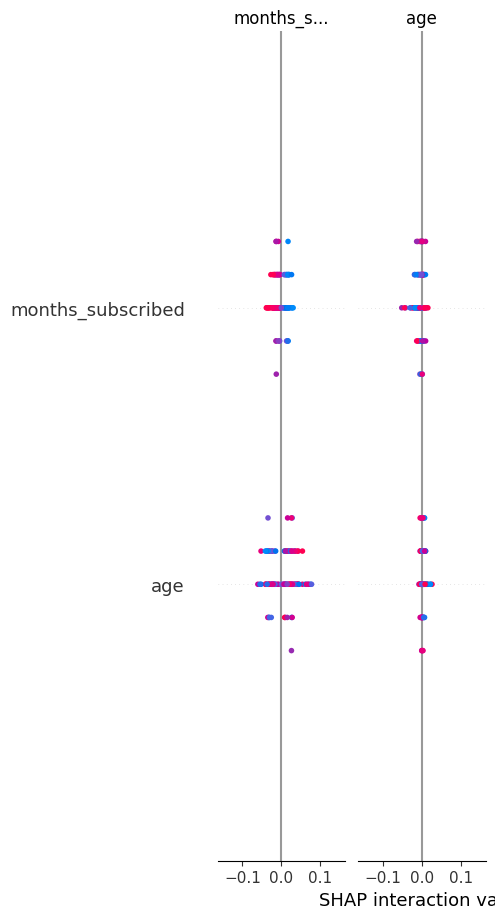

✅ Saved shap_summary.png


In [128]:
# ========================================
# PHASE 5: MODEL EXPLAINABILITY (SHAP)
# ========================================

%pip install pandas numpy scikit-learn shap matplotlib joblib streamlit


import pandas as pd
import numpy as np
import shap  
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score, precision_score



print("🚀 Phase 5: SHAP Explainability Starting...")

# 1. LOAD DATA & MODEL
print("\n1. Loading test data & best model...")
X_test = pd.read_csv("X_test_fe.csv")
y_test = pd.read_csv("y_test.csv").squeeze()
model = joblib.load("best_churn_model_rf.pkl")

print(f"✓ X_test shape: {X_test.shape}")
print(f"✓ Model: {type(model).__name__}")

# 2. SAMPLE FOR PLOTTING (faster)
X_sample = X_test.sample(min(500, len(X_test)), random_state=42)

# 3. CREATE SHAP EXPLAINER
print("\n2. Creating TreeExplainer...")
explainer = shap.TreeExplainer(model)  # ← NOW WORKS!
shap_values_raw = explainer.shap_values(X_sample)

# BULLETPROOF HANDLING
print("DEBUG - Raw SHAP type:", type(shap_values_raw))
if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1]  # Churn class
    base_val = float(explainer.expected_value[1])
    print("✓ Binary classifier detected")
else:
    shap_values = shap_values_raw
    base_val = float(explainer.expected_value[0] if hasattr(explainer.expected_value, '__len__') else explainer.expected_value)
    print("✓ Single output detected")

print(f"✅ SHAP complete!")
print(f"   SHAP shape: {shap_values.shape}")
print(f"   Base value: {base_val:.3f}")

# 4. SAVE EXPLAINER FOR STREAMLIT
joblib.dump(explainer, "churn_explainer.pkl")
print("✅ SAVED: churn_explainer.pkl")

# 5. GLOBAL PLOTS
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values[:100], X_sample.iloc[:100], max_display=10, show=False)
plt.savefig("shap_summary.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Saved shap_summary.png")









In [129]:
# Add at TOP of cell
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]


In [130]:
# For Colab/JupyterLab
from IPython.display import display
display(plt.gcf())


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

✅ FILE SAVED: shap_summary.png


<Figure size 1000x600 with 0 Axes>

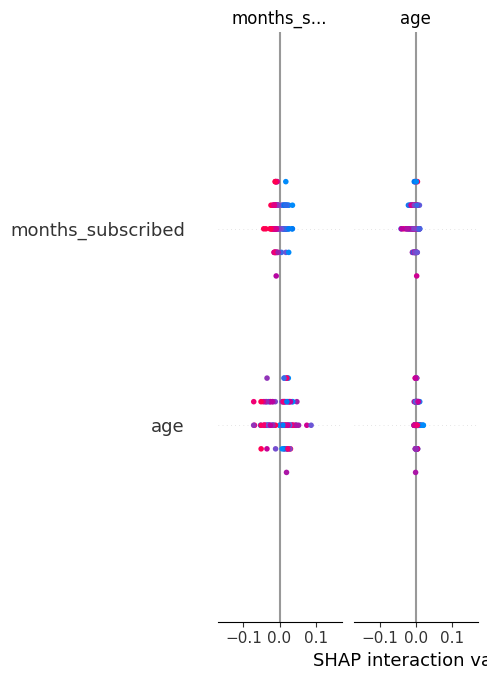

In [131]:
# MINIMAL VERSION - SAVES FILES EVEN IF NO DISPLAY
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.head(100))

plt.figure()
shap.summary_plot(shap_values, X_test.head(100), show=False)
plt.savefig("shap_summary.png", dpi=300, bbox_inches="tight")
print("✅ FILE SAVED: shap_summary.png")


In [132]:
# ========================================
# PHASE 6: DEPLOYMENT (STREAMLIT APP)
# ========================================

# CREATE ALL REQUIRED FILES (Run this FIRST in Jupyter) - FIXED
import joblib
import pandas as pd
import shap
import os  # ← ADD THIS LINE
from sklearn.metrics import roc_auc_score, recall_score, precision_score

# Load your Phase 4 outputs
print("🔍 Checking existing files...")
X_test = pd.read_csv("X_test_fe.csv")
y_test = pd.read_csv("y_test.csv").squeeze()
model = joblib.load("best_churn_model_rf.pkl")

print("✅ Phase 4 files found!")

# Create SHAP explainer & save
print("Creating churn_explainer.pkl...")
explainer = shap.TreeExplainer(model)
joblib.dump(explainer, "churn_explainer.pkl")
print("✅ Saved churn_explainer.pkl")

# Verify all files exist
required_files = ["best_churn_model_rf.pkl", "churn_explainer.pkl", "X_test_fe.csv", "y_test.csv"]
print("\n📁 FILE CHECK:")
for f in required_files:
    status = "✅" if os.path.exists(f) else "❌"
    print(f"{status} {f}")

print("\n🎉 All files ready for Streamlit!")
print("\n🚀 NEXT: Open terminal → `streamlit run app.py`")




  
 



🔍 Checking existing files...
✅ Phase 4 files found!
Creating churn_explainer.pkl...
✅ Saved churn_explainer.pkl

📁 FILE CHECK:
✅ best_churn_model_rf.pkl
✅ churn_explainer.pkl
✅ X_test_fe.csv
✅ y_test.csv

🎉 All files ready for Streamlit!

🚀 NEXT: Open terminal → `streamlit run app.py`


In [133]:
import os
print("📁 YOUR PROJECT FOLDER PATH:")
print(os.getcwd())
print("\n📋 Full path with files:")
!dir

📁 YOUR PROJECT FOLDER PATH:
c:\Users\rithw\PYTHON_CHURN_ PROJECT

📋 Full path with files:
 Volume in drive C is OS
 Volume Serial Number is CEBD-2E10

 Directory of c:\Users\rithw\PYTHON_CHURN_ PROJECT

23-12-2025  18:55    <DIR>          .
23-12-2025  18:55    <DIR>          ..
23-12-2025  18:35    <DIR>          .venv
23-12-2025  18:55        26,342,585 best_churn_model_rf.pkl
23-12-2025  18:56        35,067,222 churn_explainer.pkl
23-12-2025  18:55               463 model_performance_summary.csv
23-12-2025  17:51           737,935 PYTHON_CHURN_PROJECT.ipynb
23-12-2025  17:43               118 requirements.txt.txt
23-12-2025  18:56            77,133 shap_summary.png
23-12-2025  18:54         2,509,151 streaming_churn_20k.csv
23-12-2025  18:54         2,244,748 X_test_fe.csv
23-12-2025  18:54         5,236,507 X_train_fe.csv
23-12-2025  18:54            18,007 y_test.csv
23-12-2025  18:54            42,007 y_train.csv
              11 File(s)     72,275,876 bytes
               3 Dir(

In [134]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score, precision_score

st.set_page_config(page_title="Streaming Churn Predictor", layout="wide")

st.title("📺 Streaming Churn Predictor")

@st.cache_resource
def load_models():
    model = joblib.load("best_churn_model_rf.pkl")
    explainer = joblib.load("churn_explainer.pkl")
    return model, explainer

@st.cache_data
def load_data():
    X_test = pd.read_csv("X_test_fe.csv")
    y_test = pd.read_csv("y_test.csv").squeeze()
    return X_test, y_test

model, explainer = load_models()
X_test, y_test = load_data()

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

col1, col2, col3 = st.columns(3)
col1.metric("ROC-AUC", f"{roc_auc_score(y_test, y_proba):.3f}")
col2.metric("Recall", f"{recall_score(y_test, y_pred):.3f}")
col3.metric("Precision", f"{precision_score(y_test, y_pred):.3f}")

tab1, tab2, tab3 = st.tabs(["🔮 Predict", "🧠 Explain", "🎯 Insights"])

with tab1:
    st.header("🔮 Single User Prediction")
    col1, col2 = st.columns(2)
    with col1:
        age = st.slider("Age", 18, 70, 35)
        watch_30d = st.slider("Watch Hours 30d", 0, 120, 25)
    with col2:
        days_inactive = st.slider("Days Inactive", 0, 45, 5)
        payment_fails = st.slider("Payment Failures", 0, 6, 0)
    
    if st.button("Predict", type="primary"):
        user_df = pd.DataFrame({
            'age': [age], 'watchhours30d': [watch_30d],
            'days_since_last_watch': [days_inactive],
            'paymentfailures': [payment_fails]
        }).reindex(columns=X_test.columns, fill_value=0)
        
        prob = model.predict_proba(user_df)[0, 1]
        st.metric("Churn Risk", f"{prob:.1%}")

with tab2:
    st.header("🧠 SHAP Waterfall Plot")
    
    # ✅ BULLETPROOF SINGLE SAMPLE SELECTION
    try:
        if st.radio("User type:", ["High-risk", "Low-risk"]) == "High-risk":
            risky_indices = X_test[y_proba > 0.7].index
            sample_idx = risky_indices[0] if len(risky_indices) > 0 else X_test.index[0]
        else:
            safe_indices = X_test[y_proba < 0.3].index
            sample_idx = safe_indices[0] if len(safe_indices) > 0 else X_test.index[0]
        
        # SINGLE ROW (shape: 1,n_features)
        single_row = X_test.loc[[sample_idx]]
        
        # SINGLE EXPLANATION (shape: n_features,)
        explanation = explainer(single_row)[0]
        
        plt.figure(figsize=(12, 8))
        shap.plots.waterfall(explanation, max_display=12, show=False)
        st.pyplot(plt.gcf())
        plt.close()
        
        st.success(f"✅ Plot generated for sample {sample_idx}")
        
    except Exception as e:
        st.error(f"SHAP Error: {e}")
        st.info("Try running Phase 5 explainer creation first")

with tab3:
    st.header("🎯 Insights")
    st.write("**Top Churn Drivers:**")
    st.write("- Days inactive (>30 days)")
    st.write("- Engagement drop") 
    st.write("- Payment failures")


2025-12-23 18:56:02.930 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 18:56:02.931 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 18:56:02.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 18:56:02.933 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 18:56:02.935 No runtime found, using MemoryCacheStorageManager
2025-12-23 18:56:03.081 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 18:56:03.082 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 18:56:03.082 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 18:56:03.082 Thread 'MainThread':

<Figure size 1200x800 with 0 Axes>